In [68]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import Accuracy, F1Score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("text.csv")
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### Data Cleaning
1. Removing white space
2. Removing not numbers or letter characters
4. Lowercasing
5. Removeing stop words
6. Removing URLs
7. Removign Number
8. Removing specical character

In [6]:
def text_cleaning(text, stopwords):
    # removing space
    text = text.str.replace(r'\s+', ' ', regex = True)
    # removing non number and letter characters
    text = text.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    # lowercasing
    text = text.str.lower()
    # removing stop words
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # removing number
    text = text.str.replace(r'\d+', '', regex = True)
    # removing url
    text = text.str.replace(r'http\S+', '', regex = True)
    # removing special character
    text = text.str.replace(r'[^\w\s]', '', regex = True)
    # removing url
    text = text.str.replace(r'http\S+', '', regex = True)

    return text

In [7]:
stopwords_list = stopwords.words('english')
df['text'] = text_cleaning(df['text'], stopwords_list)

### Split Train Test Set

In [8]:
X = df['text']
y = df['label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (333447,)
The shape of X_test is  (83362,)
The shape of y_train is (333447,)
The shape of y_test is (83362,)


### Tokenization

- Splitting all the input text in to words, even punctuation
- Convert all the tokenized input into **numerical sequences**

In [48]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_idx = tokenizer.word_index

In [49]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
maxlength = max(len(tokens) for tokens in X_train_seq)
print(maxlength)

79


### Padding Puzzle
- Add padding to the converted sequences to make sure all the inputs will have the same lenght for LSTM

In [16]:
X_train_padded = pad_sequences(X_train_seq, maxlen = maxlength, padding = "post")
X_test_padded = pad_sequences(X_test_seq, maxlen = maxlength, padding = "post")

In [17]:
input_size = np.max(X_train_padded) + 1
input_size

60000

### Embeddings with FastText
- Represent the number we converted from the tokens (with tokenization) with vectors
- FastText
    - Learns embeddings for character n-grams
- The return of all these methods are usually a dictionary
    - key: a word in the corpus
    - value: a vector of size N

In [18]:
def load_vectors(fname):
    fin = io.open(
        fname,
        'r',
        encoding = "utf-8",
        newline = "\n",
        errors = "ignore"
    )
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [21]:
embeddings = load_vectors("crawl-300d-2M.vec")
embedding_dim = len(embeddings[first])

In [54]:
embedding_matrix = np.zeros((len(word_idx) + 1, embedding_dim))

In [56]:
for word, idx in word_idx.items():
    if embeddings.get(word):
        embedding_matrix[idx] = embeddings[word]

### LSTM

- Embedding Layer
  - Weights: embedding_matrix
  - input_length: maxlength after tokenization
- Activation Function: Relu
- Add a convolution layer and a Max Pooling layer to capture the relations in the input sequences and reduce the dimensionalities
- LSTM: Bidirection LSTM

In [66]:
model = Sequential([Embedding(len(word_idx) + 1, 
                              embedding_dim, input_length = maxlength,
                              weights = [embedding_matrix], trainable = False), 
                   Dropout(0,1), 
                   Conv1D(128, 5, activation = 'relu'),
                   MaxPooling1D(pool_size = 5),
                   Bidirectional(LSTM(64)),
                   Dropout(0.1),
                   Dense(512, activation = 'relu'),
                   Dropout(0.1),
                   Dense(len(y.unique()), activation = 'softmax')])

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = RMSprop(0.002),
             metrics = ['accuracy'])

history = model.fit(X_train_padded, y_train, 
                    epochs = 30, 
                    validation_data = (X_test_padded, y_test))

Epoch 1/30
10421/10421 [==============================] - 180s 17ms/step - loss: 0.2049 - accuracy: 0.9113 - val_loss: 0.1521 - val_accuracy: 0.9271
Epoch 2/30
10421/10421 [==============================] - 183s 18ms/step - loss: 0.1451 - accuracy: 0.9307 - val_loss: 0.1514 - val_accuracy: 0.9278
Epoch 3/30
10421/10421 [==============================] - 187s 18ms/step - loss: 0.1403 - accuracy: 0.9332 - val_loss: 0.1645 - val_accuracy: 0.9308
Epoch 4/30
10421/10421 [==============================] - 192s 18ms/step - loss: 0.1400 - accuracy: 0.9337 - val_loss: 0.1685 - val_accuracy: 0.9307
Epoch 5/30
10421/10421 [==============================] - 194s 19ms/step - loss: 0.1355 - accuracy: 0.9352 - val_loss: 0.1738 - val_accuracy: 0.9304
Epoch 6/30
10421/10421 [==============================] - 194s 19ms/step - loss: 0.1348 - accuracy: 0.9354 - val_loss: 0.1983 - val_accuracy: 0.9281
Epoch 7/30
10421/10421 [==============================] - 201s 19ms/step - loss: 0.1334 - accuracy: 0.9360

#### Training History
From the training history plot below we find that no overfitting is observed, and the accuracy is quite good - around 93%, which indicates that we have successfully trained a good classifier for emotion classification from textual tweets.

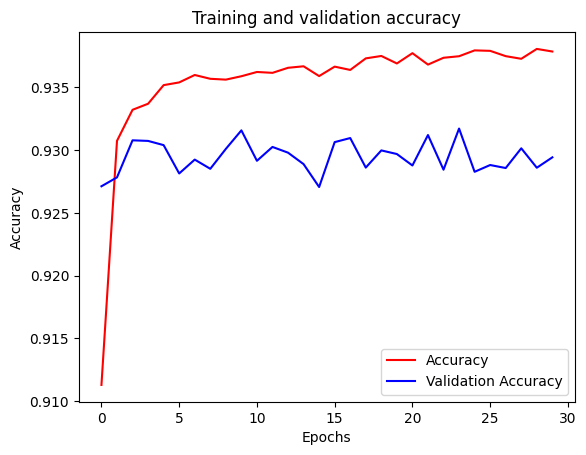

In [67]:
epochs = [*range(30)]

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [69]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
print("Classification report:\n", classification_report(y_test, y_pred))

2606/2606 [==============================] - 18s 7ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     24201
           1       0.98      0.91      0.94     28164
           2       0.76      0.97      0.85      6929
           3       0.91      0.97      0.94     11441
           4       0.92      0.86      0.89      9594
           5       0.74      0.93      0.83      3033

    accuracy                           0.93     83362
   macro avg       0.88      0.93      0.90     83362
weighted avg       0.94      0.93      0.93     83362

